Notebook for implementing DMRG tree structure optimization on tensor network level. 

In [1]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")



edge_weights_update_DRMG_chi_max (generic function with 1 method)

In [2]:



function replace_index(tensor, replace_inds, new_inds)
    
    mapping = Dict(zip(replace_inds, new_inds))
    #display(mapping)
    current_inds = inds(tensor)
    ids = []
    for id in current_inds
        if id in replace_inds
            push!(ids, mapping[id])
        else
            push!(ids, id)
        end
    end
    new_tensor = Tenet.Tensor(tensor.data, [ids...])
    return new_tensor
end


function extract_partial_tn_loop(TN, cycle, printing = false)
    tensors_in_loop = collect(Set([tensor for id in cycle for tensor in Tenet.select(TN, Symbol(id))])) #correct orderding of variable definitions
    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    #drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
    #display(drawing1)
    index_cut = Symbol(cycle[1])
    edge_tensors = Tenet.select(TN, index_cut)

    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    
    return current_tn
end



function generate_unique_symbols(existing_indices::Vector{Symbol}, l::Int, min_value::Int=1, max_value::Int=200)

    """
    Function which generates a list of new symbols for index replacing capability
    """

    existing_integers = [parse(Int, string(id)) for id in existing_indices]
    potential_length = round(Int, 4*l)  # Generate at least twice the desired length
    new_symbols = []
    for i in 1:potential_length
        number = rand(min_value:max_value)
        if !in(number, existing_integers)
            if !in(number, new_symbols)
                push!(new_symbols, number)
            end
        end
        if length(new_symbols) == l
            new_symbols = [Symbol(new) for new in new_symbols]
            break
        end
    end


  
    return new_symbols
  
end

function collect_tensors_along_loop(loop_tn, index_cycle, edge_to_cut)

    """
    Funtion whcih sequentially walks along the loop and selects the relevant tensors
    """

    connectedtensors = Tenet.select(loop_tn, Symbol(edge_to_cut))
    firstsymbol = Symbol(index_cycle[1])
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end
    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != parse(Int, string(connecting_id[1])), index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end
end


function create_index_isomorphismgroup(size_index1, size_index2, indices)
    n = size_index1*size_index2
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (size_index1, size_index2, n))
    println("A grouping has been created: ", indices[1:2], "==>", indices[3])
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [(indices...)])
    return identity_isomorphism
end


function create_index_isomorphismsplit(propagation_size, cut_size, new_indices, propagation_index)
    size_id_to_tensor = convert(Int64, propagation_size/cut_size)
    size_loop_part = cut_size
    n = propagation_size
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (propagation_size, size_id_to_tensor, size_loop_part))
    println("A splitting has been created: ", propagation_index, "==>", new_indices[1:2])
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [propagation_index, new_indices...])
    return identity_isomorphism
end



create_index_isomorphismsplit (generic function with 1 method)

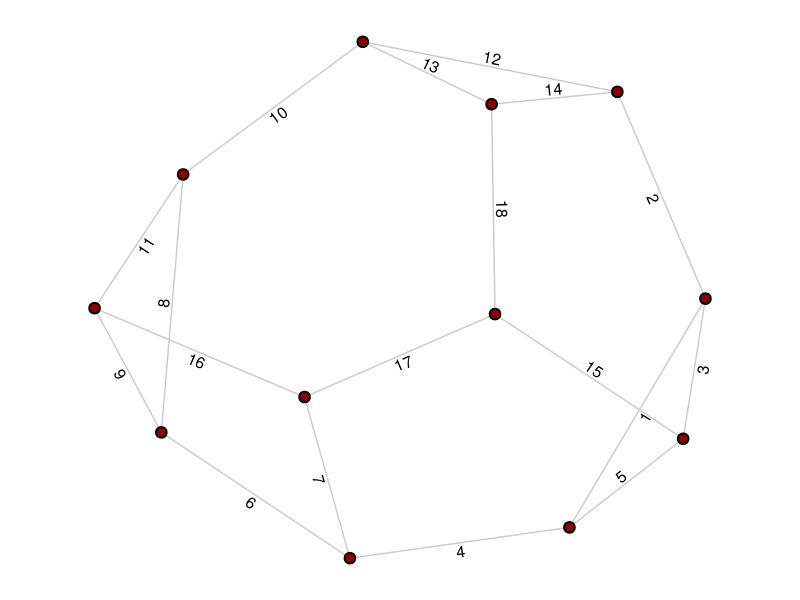

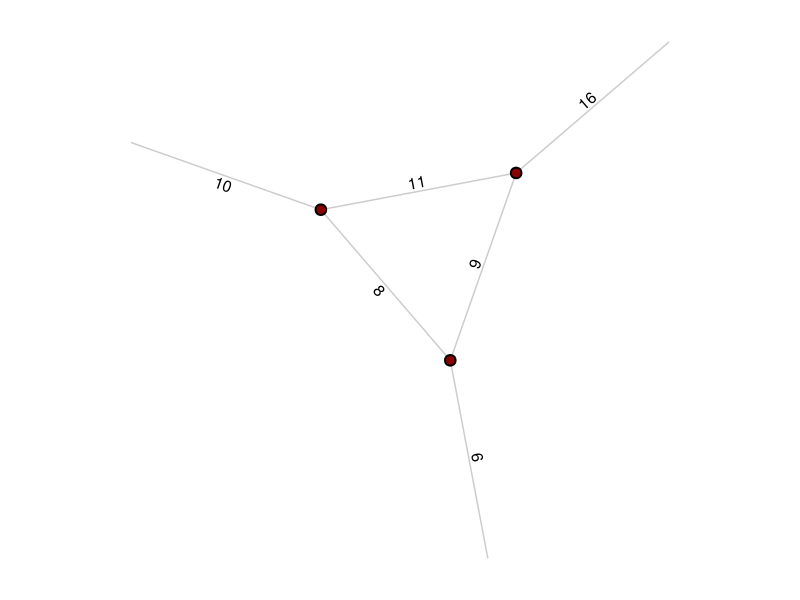

[8, 11]
[Symbol("6"), Symbol("8"), Symbol("9")]
[Symbol("8"), Symbol("10"), Symbol("11")]
[Symbol("9"), Symbol("11"), Symbol("16")]
[Symbol("8"), Symbol("9")]
A grouping has been created: [Symbol("58"), Symbol("26")]==>179
indices tensor 1[Symbol("6"), Symbol("58"), Symbol("26")]with sizes[2, 2, 2]
indices identity_1:[Symbol("58"), Symbol("26"), Symbol("179")]with sizes[2, 2, 4]
A splitting has been created: 179==>[Symbol("153"), Symbol("181")]
replacement legs:[Symbol("8"), Symbol("11")]
replacement legs:[Symbol("8"), Symbol("11")]
A grouping has been created: [Symbol("181"), Symbol("97")]==>22
indices identity_1_inv 1[Symbol("179"), Symbol("153"), Symbol("181")]with sizes[4, 2, 2]
indices tensor 2[Symbol("153"), Symbol("10"), Symbol("97")]with sizes[2, 2, 2]
indices identity 2[Symbol("181"), Symbol("97"), Symbol("22")]with sizes[2, 2, 4]
A splitting has been created: 22==>[Symbol("54"), Symbol("36")]
indices identity_1_inv 2[Symbol("22"), Symbol("54"), Symbol("36")]with sizes[4, 2, 2

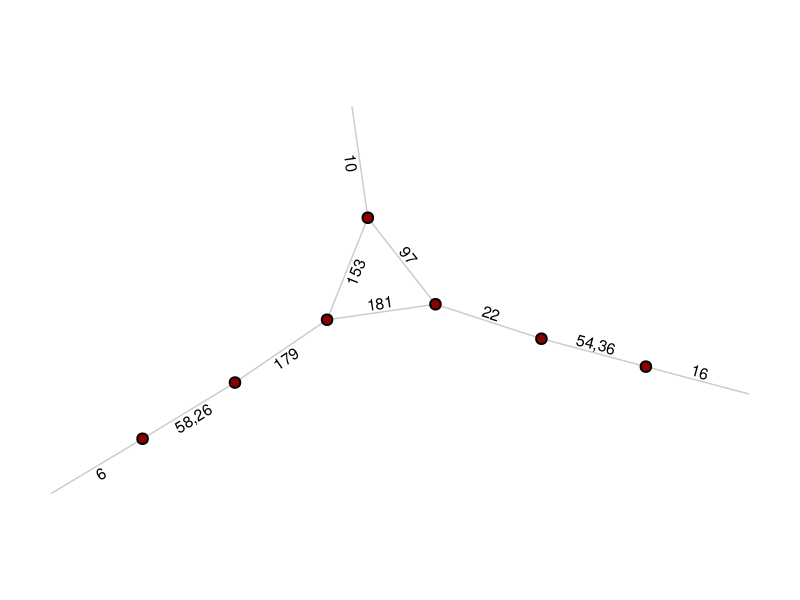

2×2×2 Tensor{Float64, 3, Array{Float64, 3}}:
[:, :, 1] =
 1.01268   0.473217
 0.806092  0.266256

[:, :, 2] =
 1.25131  0.80636
 1.06132  0.447457

2×2×2 Tensor{Float64, 3, Array{Float64, 3}}:
[:, :, 1] =
 1.01268   0.473217
 0.806092  0.266256

[:, :, 2] =
 1.25131  0.80636
 1.06132  0.447457

In [3]:
# Implement a frucht graph TN, try to selected a cycle to transform into DMRG approachable tree

dimension = 2
G = Graphs.smallgraph(:frucht)
tn1 = fill_with_random(G, dimension, false, true)
locs_x =     [4, 4, -5, -2, 0, 0, 2, 0, -3, -1, -6, -4]
locs_y = -1*[-2, 1, -2, -1, 0, -2, 0, 3, 3, 1, 1, 0]
g, tensordict, edgesdict, fully_weighted_edge_list, edge_index_map = extract_graph_representation(tn1, false)

drawing1 = Makie.plot(tn1, node_color=[:darkred for i in 1:length(tensors(tn1))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)




function reorganize_cycle(cycle::Vector{Int}, selected_edge::Int)
    
    if idx === nothing
        println("Selected edge not found in the cycle.")
        return cycle
    end
    new_cycle = vcat(cycle[idx+1:end], cycle[1:idx-1])
    return new_cycle
end




function transform_to_MPS(TN, edge_to_cut, index_cycle, printing=false)

    """
    Function which takes in a tensor network, a cycle of indices
    and an edge to cut, returns the MPS like structured TensorNetwork instead
    of the loop TensorNetwork.
    """
    
    inds_in_use = inds(TN)
    loop_tn = extract_partial_tn_loop(TN, index_cycle, true)
    
    n = length(tensors(loop_tn))
    
    # Generate an adequate amount of new indices to be used inside of the
    # virtual tensor structure
    new_inds = generate_unique_symbols(inds_in_use, 4*n-3)

    #collect tensors along the loop from start_tensor to end_tensor
    #reorganize_cycle for correct ordering along the loop
    idx = findfirst(isequal(edge_to_cut), index_cycle)
    index_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
    println(index_cycle)
    ordered_along_loop = collect_tensors_along_loop(loop_tn, deepcopy(index_cycle), edge_to_cut)
    # is this done in a good manner?

    for tensor in ordered_along_loop
        println(inds(tensor))
    end
    
    # now use the defined cycle to push the correct tensor indices inside of the
    # grouping and splittings in the bulk and edges
    # list for the new tensors inside of the tensor network
    new_tn_tensors = []
    global contract_list = []
    global propagating_size
    global cut_size
    global propagating_index

    #remodify the index cycle for this code to work properly
    pushfirst!(index_cycle, edge_to_cut)
    # walk along the loop and make the necessary alterations at each step
    for (i, tensor) in enumerate(ordered_along_loop)

        # cases on the edges of the tensor network loop are treated seperately
        if i == 1
            # initial grouping and determine the cut_
            # size of the index which is being collapsed
            cut_size = [size(tensor, id) for id in inds(tensor) if id == Symbol(edge_to_cut)][1]
            new_virtual_inds = deepcopy(new_inds[1:3])
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            replace_leg = intersect(inds(tensor), [Symbol(id) for id in index_cycle])
            println(replace_leg)
            iso = create_index_isomorphismgroup(size(tensor, replace_leg[1]), size(tensor, replace_leg[2]), new_virtual_inds)            
            new_tensor = replace_index(tensor, replace_leg, new_virtual_inds[1:2])
            contract_list = vcat(contract_list, new_virtual_inds[1:2])
            push!(new_tn_tensors, new_tensor)

            if printing == true
                println("indices tensor $(i)", inds(new_tensor), "with sizes", [size(new_tensor, id) for id in inds(new_tensor)])
                println("indices identity_1:", inds(iso), "with sizes", [size(iso, id) for id in inds(iso)])
            end

            push!(new_tn_tensors, iso)
            propagating_index = inds(iso)[end]
            propagating_size = size(iso, propagating_index)
            continue
        end

        if i == length(ordered_along_loop)
            
            new_virtual_inds = deepcopy(new_inds[end-1:end])
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            replace_leg = intersect(inds(tensor), [Symbol(id) for id in index_cycle])
            iso_inv = create_index_isomorphismsplit(propagating_size, cut_size, new_virtual_inds, propagating_index)
            new_tensor = replace_index(tensor, replace_leg, new_virtual_inds)
            if printing == true
                println("indices identity_1_inv $(i-1)", inds(iso_inv), "with sizes", [size(iso_inv, id) for id in inds(iso_inv)])
                println("indices tensor $(i)", inds(new_tensor), "with sizes", [size(new_tensor, id) for id in inds(new_tensor)])
            end
            contract_list = vcat(contract_list, new_virtual_inds[1:2])
            push!(new_tn_tensors, new_tensor)
            push!(new_tn_tensors, iso_inv)
            break
        end
        
        # General "bulk" case
        new_virtual_inds = new_inds[4+(i-2)*4:4+(i-1)*4-1]
        iso_inv = create_index_isomorphismsplit(propagating_size, cut_size, [new_virtual_inds[1], new_virtual_inds[2]], propagating_index)
        current_inds = inds(tensor)
        dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
        replace_leg = intersect(inds(tensor),[Symbol(id) for id in index_cycle])
        println("replacement legs:", replace_leg)
        replace_leg_order = [parse(Int, string(id)) for id in replace_leg]
        leg1_id = findfirst(x -> x == replace_leg_order[1], index_cycle)
        leg2_id = findfirst(x -> x == replace_leg_order[2], index_cycle)
        #possible reshuffling
        if leg2_id < leg1_id
            replace_leg = [replace_leg[2], replace_leg[1]]                      # get the right orderding of tensor indices
        end
        println("replacement legs:", replace_leg)
        new_tensor = replace_index(tensor, replace_leg, [new_virtual_inds[1], new_virtual_inds[3]])
        iso = create_index_isomorphismgroup(cut_size, size(new_tensor, new_virtual_inds[3]), [new_virtual_inds[2], new_virtual_inds[3], new_virtual_inds[4]])
        propagating_index = inds(iso)[end]
        propagating_size = size(iso, propagating_index)

        if printing == true
            println("indices identity_1_inv $(i-1)", inds(iso_inv), "with sizes", [size(iso_inv, id) for id in inds(iso_inv)])
            println("indices tensor $(i)", inds(new_tensor), "with sizes", [size(new_tensor, id) for id in inds(new_tensor)])
            println("indices identity $(i)", inds(iso), "with sizes", [size(iso, id) for id in inds(iso)])
        end

        contract_list = vcat(contract_list, new_virtual_inds[1:3])

        push!(new_tn_tensors, iso_inv)
        push!(new_tn_tensors, new_tensor)
        push!(new_tn_tensors, iso)


    end



    return Tenet.TensorNetwork(new_tn_tensors), contract_list




    
    
   

end


example_cycle = [8, 11, 9]
#example_cycle = [ 15, 3, 2, 14, 18]
mps_network, contract_list = transform_to_MPS(tn1, example_cycle[3], example_cycle, true)
loop_tn = extract_partial_tn_loop(tn1, example_cycle)


# for id in contract_list
#     #contracting two tensors contracts fully along all shared indices
#     # --> not everything in the list will be in the tensornetwork
#     if id ∈ inds(mps_network)
#         contraction_step(mps_network, [id])
#     end
   
# end
drawing1 = Makie.plot(mps_network, node_color=[:darkred for i in 1:length(tensors(mps_network))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)




# ### Comparing loop TN with MPS TN
# contract_list_loop = inds(loop_tn, :inner)


# for id in contract_list_loop
#     if id ∈ inds(loop_tn)
#         contraction_step(loop_tn, [id])
#     end
# end



# contract_list_MPS = inds(mps_network, :inner)

# for id in contract_list_MPS
#     if id ∈ inds(mps_network)
#         contraction_step(mps_network, [id])
#     end
# end


t1 = Tenet.contract(loop_tn)
t2 = Tenet.contract(mps_network)

println("original loop contracted")
display(t1)
println("mps representation contracted")
display(t2)

println("original loop norm ", norm(t1))
println("reshaped mps representation norm ", norm(t2))



2×2×2×2 Tensor{Int64, 4, Array{Int64, 4}}:
[:, :, 1, 1] =
 1  0
 0  0

[:, :, 2, 1] =
 0  0
 1  0

[:, :, 1, 2] =
 0  1
 0  0

[:, :, 2, 2] =
 0  0
 0  1

4×4 Matrix{Int64}:
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

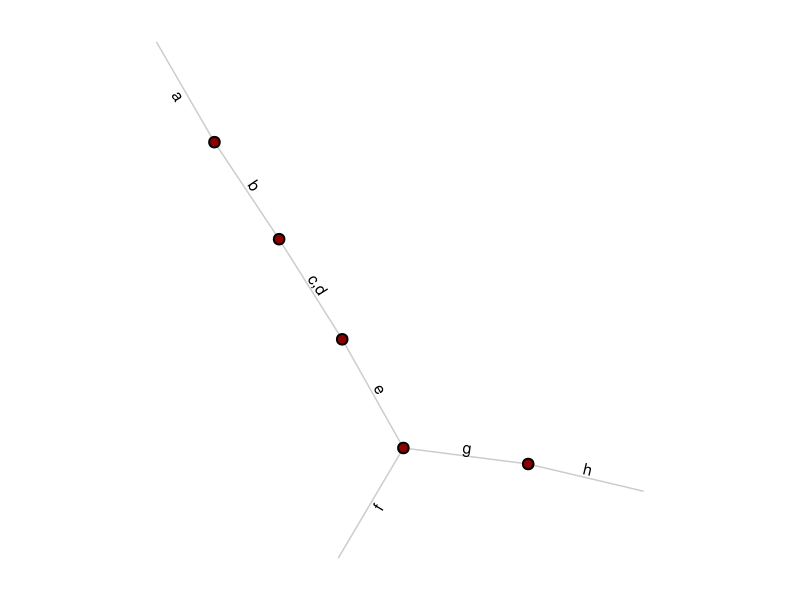

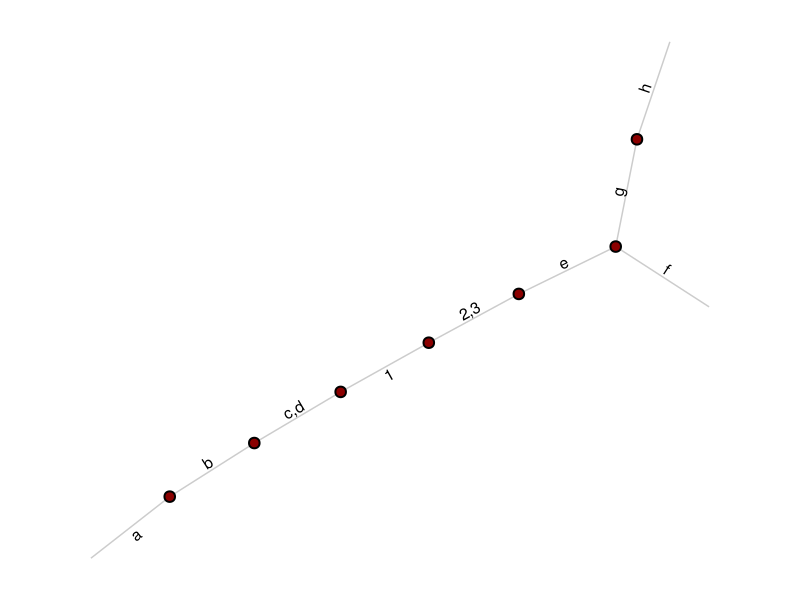

A grouping has been created: (:c, :d)==>1
2
2
4
A splitting has been created: 1==>[Symbol("2"), Symbol("3")]
printing the shape of X_inv * X
original loop contracted
mps representation contracted


2×2×2 Tensor{Float64, 3, Array{Float64, 3}}:
[:, :, 1] =
 0.342704   0.300205
 0.0649005  0.053903

[:, :, 2] =
 1.08303   0.943097
 0.205417  0.170337

2×2×2 Tensor{Float64, 3, Array{Float64, 3}}:
[:, :, 1] =
 0.342704   0.300205
 0.0649005  0.053903

[:, :, 2] =
 1.08303   0.943097
 0.205417  0.170337

In [4]:
# Testing the influence of inserting groupings inside of A TN
# ==> Figure out what is causing the swap of dimensions

dim = 2


T1L = Tensor(rand(dim,dim), (:a, :b))
T2 = Tensor(rand(dim,dim,dim), (:b, :c, :d))
T3 = Tensor(rand(dim,dim,dim), (:c, :d, :e))
T4 = Tensor(rand(dim, dim, dim), (:e, :f, :g))
T5R = Tensor(rand(dim, dim), (:g, :h))

tensorslist = [T1L, T2, T3, T4, T5R]

original_network = TensorNetwork(tensorslist)

new_inds = [Symbol(i) for i in 1:10]
group1 = create_index_isomorphismgroup(dim, dim, (:c, :d, new_inds[1]))
for i in inds(group1)
    println(size(group1, i))
end
split1 = create_index_isomorphismsplit(Int(dim*dim), dim, [new_inds[2], new_inds[3]], Symbol(1))
new_T3 = replace_index(T3, [:c, :d], [new_inds[2], new_inds[3]])




println("printing the shape of X_inv * X")
c = Tenet.contract(group1, split1)
display(c)
display(reshape(c.data, (4,4)))




tensorslist2 = [T1L, T2, group1, split1, new_T3, T4, T5R]

tn = TensorNetwork(tensorslist2)


drawing1 = Makie.plot(original_network, node_color=[:darkred for i in 1:length(tensors(original_network))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)


drawing1 = Makie.plot(tn, node_color=[:darkred for i in 1:length(tensors(tn))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)

# ### Comparing TN with identity TN
# contract_list1 = inds(original_network, :inner)

# for id in contract_list1
#     if id ∈ inds(original_network)
#         contraction_step(original_network, [id])
#     end
# end

t1 = Tenet.contract(original_network)



# contract_list2 = inds(tn, :inner)
# #contraction_step(tn, [Symbol(1)])
# for id in contract_list2
#     if id ∈ inds(tn)
#         contraction_step(tn, [id])
#     end
# end


#t1 = tensors(original_network)[1]
t2 = Tenet.contract(tn)

println("original loop contracted")
display(t1)
println("mps representation contracted")
display(t2)





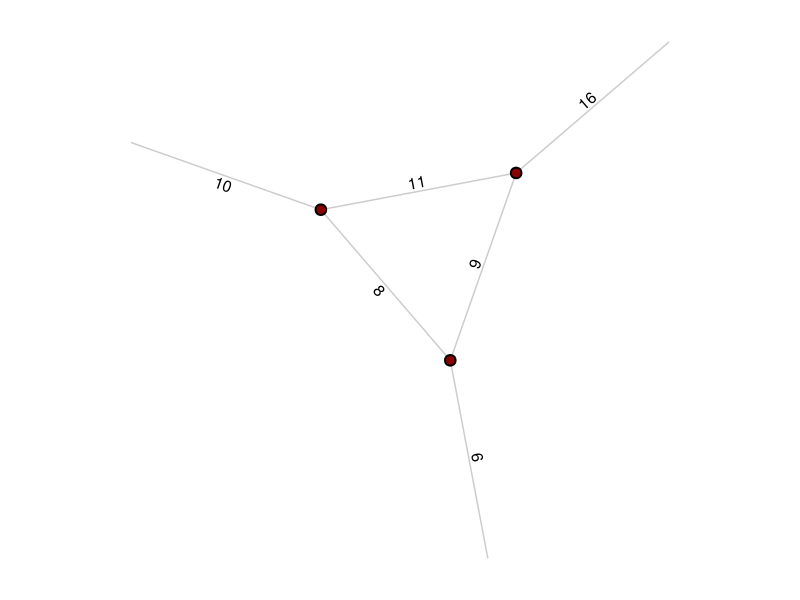

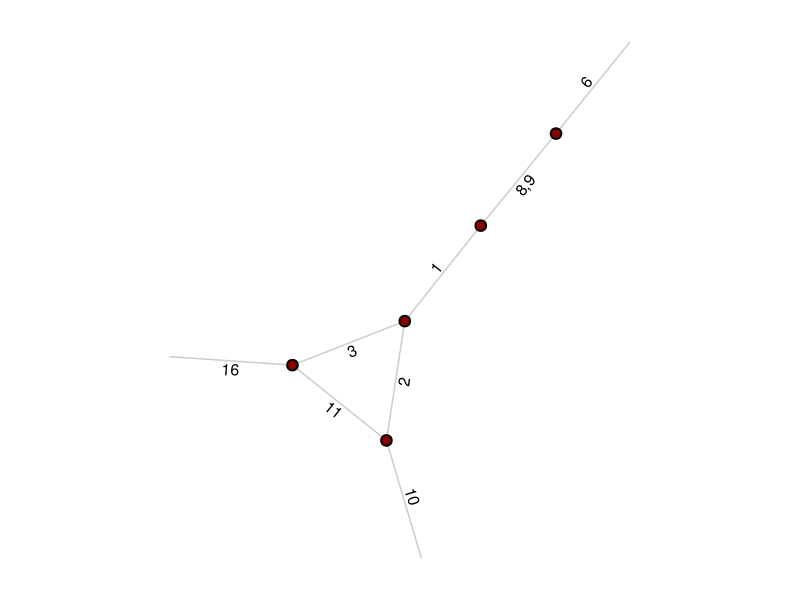

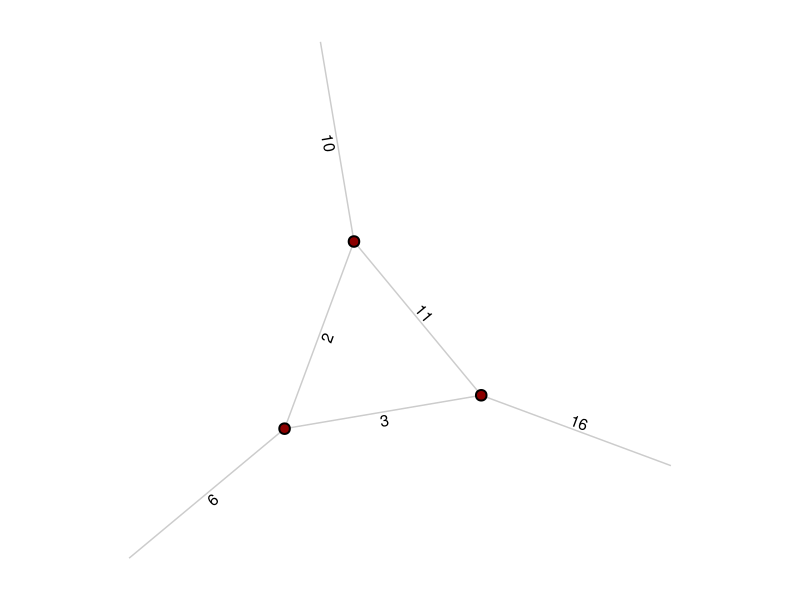

[Symbol("6"), Symbol("8"), Symbol("9")]
[Symbol("8"), Symbol("10"), Symbol("11")]
[Symbol("9"), Symbol("11"), Symbol("16")]
A grouping has been created: (Symbol("8"), Symbol("9"))==>1
A splitting has been created: 1==>[Symbol("2"), Symbol("3")]
original loop contracted
indentity grouping representation contracted
original loop norm 2.3479251128239156
reshaped mps representation norm 2.3479251128239156


2×2×2 Tensor{Float64, 3, Array{Float64, 3}}:
[:, :, 1] =
 1.01268   0.473217
 0.806092  0.266256

[:, :, 2] =
 1.25131  0.80636
 1.06132  0.447457

2×2×2 Tensor{Float64, 3, Array{Float64, 3}}:
[:, :, 1] =
 1.01268   1.25131
 0.473217  0.80636

[:, :, 2] =
 0.806092  1.06132
 0.266256  0.447457

In [5]:
example_cycle = [8, 11, 9]
original_network = extract_partial_tn_loop(tn1, example_cycle)
T1, T2, T3 = tensors(original_network)
for t in tensors(original_network)
    println(inds(t)) 
end

dim = 2
new_inds = [Symbol(i) for i in 1:10]
group1 = create_index_isomorphismgroup(dim, dim, (Symbol(8), Symbol(9), new_inds[1]))

split1 = create_index_isomorphismsplit(Int(dim*dim), dim, [new_inds[2], new_inds[3]], Symbol(1))
new_T2 = replace_index(T2, [Symbol(8)], [new_inds[2]])
new_T3 = replace_index(T3, [Symbol(9)], [new_inds[3]])


tensorslist2 = [T1, new_T2, group1, split1, new_T3]

tn = TensorNetwork(tensorslist2)


drawing1 = Makie.plot(original_network, node_color=[:darkred for i in 1:length(tensors(original_network))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)


drawing1 = Makie.plot(tn, node_color=[:darkred for i in 1:length(tensors(tn))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)


t1 = Tenet.contract(original_network)



# contract_list2 = inds(tn, :inner)
# #contraction_step(tn, [Symbol(1)])
# for id in contract_list2
#     if id ∈ inds(tn)
#         contraction_step(tn, [id])
#     end
# end


#t1 = tensors(original_network)[1]
contraction_step(tn, [Symbol(1)])
contraction_step(tn, [Symbol(8)])
drawing1 = Makie.plot(tn, node_color=[:darkred for i in 1:length(tensors(tn))], labels=true, layout=Stress(), edge_color=:grey80)
display(drawing1)

t2 = Tenet.contract(tn)

println("original loop contracted")
display(t1)
println("indentity grouping representation contracted")
display(t2)


println("original loop norm ", norm(t1))
println("reshaped mps representation norm ", norm(t2))
